# Loading Packages and Data

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

import re
import pandas as pd
from sklearn.model_selection import train_test_split


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
gw_sentences_df = pd.read_csv('/content/drive/MyDrive/MIDS 266/Final Project/GWStance GWSD.csv', sep='\t')

In [4]:
gw_sentences_df['stance'] = gw_sentences_df[['disagree', 'agree', 'neutral']].idxmax(axis=1)

<ipython-input-4-9ba0103f7587>:1: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  gw_sentences_df['stance'] = gw_sentences_df[['disagree', 'agree', 'neutral']].idxmax(axis=1)


In [5]:
min_values_agree = gw_sentences_df.loc[gw_sentences_df['stance'] == 'agree', 'agree'].min()
print(min_values_agree)
min_values_disagree = gw_sentences_df.loc[gw_sentences_df['stance'] == 'disagree', 'disagree'].min()
print(min_values_disagree)

0.3921433455894449
0.3794934072974424


In [6]:
def determine_political_leaning(row):
    stance = row['stance']

    if stance == 'neutral':
        if 1 >= row['neutral'] > 0.75:
            return 'center'
        elif 0.75 >= row['neutral']:
            if row['agree'] > row['disagree']:
                return 'somewhat left'
            elif row['agree'] < row['disagree']:
                return 'somewhat right'
            else:
                return 'center'
    elif stance == 'agree':
        if 0.50 >= row['agree'] > 0.35:
            return 'somewhat left'
        elif 0.75 >= row['agree'] > 0.50:
            return 'solidly left'
        elif 1 >= row['agree'] > 0.75:
            return 'very left'
    elif stance == 'disagree':
        if 0.50 >= row['disagree'] > 0.35:
            return 'somewhat right'
        elif 0.75 >= row['disagree'] > 0.50:
            return 'solidly right'
        elif 1 >= row['disagree'] > 0.75:
            return 'very right'

    return None

def categorize_sentiment(agree, disagree, neutral):
    if neutral > agree and neutral > disagree:
        return 0
    else:
        return 1

gw_sentences_df['contributes'] = gw_sentences_df.apply(lambda row: categorize_sentiment(row['agree'], row['disagree'], row['neutral']), axis=1)

gw_sentences_df['political_leaning'] = gw_sentences_df.apply(determine_political_leaning, axis=1)
gw_sentences_df['lean_target'] = gw_sentences_df['political_leaning'].map({'center': 0, 'somewhat left': 1, 'solidly left': 2, 'very left': 3, 'somewhat right': 4, 'solidly right': 5, 'very right': 6})

gw_sentences_df.drop_duplicates(keep='first', inplace=True)
gw_sentences_df = gw_sentences_df.iloc[5:]
gw_sentences_df.dropna(inplace=True)
gw_sentences_df.head(10)

<ipython-input-6-5d81b8e4edb9>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gw_sentences_df.dropna(inplace=True)


,Unnamed: 0,round,batch,sent_id,sentence,worker_0,worker_1,worker_2,worker_3,worker_4,...,worker_7,disagree,agree,neutral,guid,in_held_out_test,stance,contributes,political_leaning,lean_target
5,5,1,0,t0,Warmer-than-normal sea surface temperatures ar...,neutral,neutral,neutral,agrees,agrees,...,agrees,0.003105,0.711260,0.285634,1_0_t0,False,agree,1,solidly left,2.0
6,6,1,0,t1,We will continue to rely in part on fossil fue...,neutral,neutral,neutral,neutral,neutral,...,neutral,0.000830,0.001163,0.998006,1_0_t1,False,neutral,0,center,0.0
7,7,1,0,t10,The actual rise in sea levels measured only 1....,neutral,neutral,neutral,neutral,neutral,...,neutral,0.000802,0.001174,0.998023,1_0_t10,False,neutral,0,center,0.0
8,8,1,0,t11,Claims of global warming have been greatly exa...,disagrees,disagrees,disagrees,disagrees,disagrees,...,disagrees,0.997695,0.001171,0.001134,1_0_t11,False,disagree,1,very right,6.0
9,9,1,0,t12,The Intergovernmental Panel on Climate Change ...,neutral,disagrees,neutral,neutral,neutral,...,neutral,0.031351,0.002962,0.965687,1_0_t12,False,neutral,0,center,0.0
10,10,1,0,t13,Evidence now leans against global warming resu...,disagrees,agrees,disagrees,neutral,neutral,...,disagrees,0.535462,0.063947,0.400591,1_0_t13,True,disagree,1,solidly right,5.0
11,11,1,0,t14,Flooding has been going on forever.,disagrees,disagrees,disagrees,neutral,neutral,...,disagrees,0.710993,0.004516,0.284491,1_0_t14,False,disagree,1,solidly right,5.0
12,12,1,0,t15,Simply reducing emissions will not sufficientl...,neutral,agrees,agrees,agrees,agrees,...,agrees,0.001704,0.973336,0.024960,1_0_t15,False,agree,1,very left,3.0
13,13,1,0,t16,Climate deniers blame global warming on aliens...,disagrees,agrees,neutral,agrees,neutral,...,neutral,0.051909,0.387853,0.560239,1_0_t16,False,neutral,0,somewhat left,1.0
14,14,1,0,t17,"Global warming is inevitably going to be, at b...",disagrees,agrees,agrees,neutral,agrees,...,neutral,0.199417,0.477698,0.322885,1_0_t17,False,agree,1,somewhat left,1.0


In [7]:
moderately_left_sample = gw_sentences_df[gw_sentences_df['political_leaning'] == 'very left'].sample(n=5)
somewhat_left_sample = gw_sentences_df[gw_sentences_df['political_leaning'] == 'somewhat left'].sample(n=5)
solidly_left_sample = gw_sentences_df[gw_sentences_df['political_leaning'] == 'solidly left'].sample(n=5)

# Combine the samples into a single DataFrame
combined_sample = pd.concat([moderately_left_sample, somewhat_left_sample, solidly_left_sample])

# Display the combined sample
combined_sample[['sentence', 'stance', 'political_leaning']]

,sentence,stance,political_leaning
338,Climate change could reduce global crop produc...,agree,very left
1223,"We have about a ten-year window to make very, ...",agree,very left
1937,"If we continue to warm the planet, then we wil...",agree,very left
1128,The most important outcome of the internationa...,agree,very left
850,The only way this can be addressed is to act q...,agree,very left
505,Developing countries are paying the price for ...,neutral,somewhat left
1416,The surface temperatures of the Mediterranean ...,neutral,somewhat left
426,The latest Intergovernmental Panel on Climate ...,neutral,somewhat left
475,Sea level rise in the 20th century is mostly m...,neutral,somewhat left
1344,Obama will work with environmentalists to curb...,neutral,somewhat left


In [13]:
gw_sentences_df['political_leaning'].value_counts()

,count
political_leaning,
center,656
very left,611
very right,306
solidly left,157
somewhat left,149
somewhat right,89
solidly right,82


In [8]:
# ClimateBERT

from transformers import AutoTokenizer, TFAutoModel, BertTokenizer, TFBertModel

climatebert_tokenizer = AutoTokenizer.from_pretrained("climatebert/distilroberta-base-climate-f")
climatebert_model = TFAutoModel.from_pretrained('climatebert/distilroberta-base-climate-f')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.15M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/4.98k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/752 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [9]:
def sort_dict_by_values(input_dict):

    # Create separate sorted lists of the integer tags and the associated labels
    # We'll need this for doing analysis of the results of our classifier

    items = list(input_dict.items())

    # Convert values to floats for sorting to handle numeric strings
    items.sort(key=lambda item: float(item[1]))

    sorted_values = [item[1] for item in items]
    sorted_keys = [item[0] for item in items]

    return sorted_values, sorted_keys  # Return as a tuple

In [10]:
unique_political_leanings_targets = dict(zip(gw_sentences_df['political_leaning'].unique(), gw_sentences_df['lean_target'].unique()))
print(unique_political_leanings_targets)

{'solidly left': 2.0, 'center': 0.0, 'very right': 6.0, 'solidly right': 5.0, 'very left': 3.0, 'somewhat left': 1.0, 'somewhat right': 4.0}


In [11]:
sorted_values, sorted_keys = sort_dict_by_values(unique_political_leanings_targets)
print("Sorted Values:", sorted_values)
print("Sorted Keys:", sorted_keys)

Sorted Values: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
Sorted Keys: ['center', 'somewhat left', 'solidly left', 'very left', 'somewhat right', 'solidly right', 'very right']


In [12]:
target_names = sorted_keys
print(target_names)

['center', 'somewhat left', 'solidly left', 'very left', 'somewhat right', 'solidly right', 'very right']


# Baseline w/ regular BERT and majority class

## Majority Class

In [ ]:
# Split into train and test sets

train_sentences = gw_sentences_df['sentence'][gw_sentences_df['in_held_out_test'] == 0]
test_sentences = gw_sentences_df['sentence'][gw_sentences_df['in_held_out_test'] == 1]

print("Train and test sentence shapes:", train_sentences.shape, test_sentences.shape)

train_leaning = gw_sentences_df['lean_target'][gw_sentences_df['in_held_out_test'] == 0]
train_leaning = tf.convert_to_tensor(train_leaning, dtype=tf.int32)
test_leaning = gw_sentences_df['lean_target'][gw_sentences_df['in_held_out_test'] == 1]
test_leaning = tf.convert_to_tensor(test_leaning, dtype=tf.int32)

print("Train and test leaning shapes:",train_leaning.shape, test_leaning.shape)


Train and test sentence shapes: (1850,) (200,)
Train and test leaning shapes: (1850,) (200,)


In [ ]:
train_leaning_counts = np.unique(train_leaning, return_counts=True)
train_leaning_counts

(array([0, 1, 2, 3, 4, 5, 6], dtype=int32),
 array([592, 139, 145, 547,  76,  71, 280]))

In [ ]:
# Get test accuracy if model only answers agree.

y_pred = [2] * len(test_leaning)

# Compute the number of correct predictions
correct_predictions = sum([1 for true, pred in zip(test_leaning, y_pred) if true == pred])

# Compute accuracy
accuracy = correct_predictions / len(test_leaning)

# Print the accuracy
print(f"Majority Class Classifier Test Accuracy: {accuracy:.2f}")

Majority Class Classifier Test Accuracy: 0.06


## BERT Baseline

In [16]:
# Load baseline tokenizer and model
from transformers import BertTokenizer, TFBertModel

checkpoint = 'bert-base-cased'
bert_tokenizer = BertTokenizer.from_pretrained(checkpoint)
bert_model = TFBertModel.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [13]:
from sklearn.utils.class_weight import compute_class_weight

# stratified sampling
def advanced_stratified_sampling(df, target_col, max_per_group=500, min_per_group=50):
    # creating proportional groups
    def sample_group(group):
        sample_size = min(
            max(min_per_group, int(len(group) * 0.5)),  # 50% of original, but at least min_per_group
            max_per_group)
        return group.sample(min(len(group), sample_size))

    # sampling
    sampled_df = df.groupby(target_col, group_keys=False).apply(sample_group)

    return sampled_df

# class weights
def get_class_weights(y):
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y),
        y=y
    )
    return dict(zip(np.unique(y), class_weights))

# stratified split
def stratified_split_with_weights(df, target_col='lean_target', test_size=0.2):
    sampled_df = advanced_stratified_sampling(df, target_col)

    X = sampled_df['sentence']
    y = sampled_df[target_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        stratify=y,
        random_state=42)

    class_weights = get_class_weights(y_train)

    print("Class Distribution:")
    print(y_train.value_counts(normalize=True))
    print("\nClass Weights:")
    for cls, weight in class_weights.items():
        print(f"{cls}: {weight:.4f}")

    return {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'class_weights': class_weights
    }

result = stratified_split_with_weights(gw_sentences_df)

Class Distribution:
lean_target
0.0    0.315663
3.0    0.293976
6.0    0.146988
2.0    0.075904
1.0    0.071084
4.0    0.048193
5.0    0.048193
Name: proportion, dtype: float64

Class Weights:
0.0: 0.4526
1.0: 2.0097
2.0: 1.8821
3.0: 0.4859
4.0: 2.9643
5.0: 2.9643
6.0: 0.9719


<ipython-input-13-1472338773ba>:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby(target_col, group_keys=False).apply(sample_group)


In [14]:
def weighted_sparse_categorical_crossentropy(class_weights):

    def loss(y_true, y_pred):
        weights = tf.gather(tf.convert_to_tensor(list(class_weights.values()), dtype=tf.float32),
                            tf.cast(y_true, tf.int32))

        scce = tf.keras.losses.SparseCategoricalCrossentropy()
        unweighted_loss = scce(y_true, y_pred)

        weighted_loss = unweighted_loss * weights

        return tf.reduce_mean(weighted_loss)

    return loss

In [15]:
X_train = result['X_train']
X_test = result['X_test']
y_train = result['y_train']
y_test = result['y_test']
class_weights = result['class_weights']

In [ ]:
print(X_train)

1158         They tell us to reduce our carbon emissions.
1440    Representative Markey wants to subpoena the EP...
1316    To avoid a climate catastrophe, the world the ...
323     Carbon developers want to lock up 10,000 acres...
1471    These new results will help us answer importan...
                              ...                        
116     Damage to Great Barrier Reef From Global Warmi...
1880    The frightening speed of climate change is par...
98      If the media put global warming front and cent...
406     The sea level has been rising since the end of...
432     Global warming could spell disaster for the st...
Name: sentence, Length: 830, dtype: object


In [ ]:
print(y_train)

1158    0.0
1440    0.0
1316    3.0
323     0.0
1471    1.0
       ... 
116     3.0
1880    3.0
98      3.0
406     0.0
432     3.0
Name: lean_target, Length: 830, dtype: float64


In [ ]:
print(np.unique(y_train))

[0. 1. 2. 3. 4. 5. 6.]


In [17]:
# Get MAX_SEQUENCE_LENGTH
MAX_SEQUENCE_LENGTH = gw_sentences_df['sentence'].apply(lambda x: len(x.encode('utf-8'))).max()

print("Max UTF-8 sequence length:", MAX_SEQUENCE_LENGTH)

train_sentences_list = X_train.tolist()  # Extract the 'sentence' column and convert it to a list
test_sentences_list = X_test.tolist()   # Extract the 'sentence' column and convert it to a list

train_encodings = bert_tokenizer(train_sentences_list,
                         max_length=MAX_SEQUENCE_LENGTH,
                         padding='max_length',
                         truncation=True,
                         return_tensors='tf')
test_encodings = bert_tokenizer(test_sentences_list,
                        max_length=MAX_SEQUENCE_LENGTH,
                        padding='max_length',
                        truncation=True,
                        return_tensors='tf')


Max UTF-8 sequence length: 347


In [ ]:
print(train_encodings)

{'input_ids': <tf.Tensor: shape=(830, 347), dtype=int32, numpy=
array([[  101,  1220,  1587, ...,     0,     0,     0],
       [  101,  7725,  2392, ...,     0,     0,     0],
       [  101,  1706,  3644, ...,     0,     0,     0],
       ...,
       [  101,  1409,  1103, ...,     0,     0,     0],
       [  101,  1109,  2343, ...,     0,     0,     0],
       [  101,  5357, 14110, ...,     0,     0,     0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(830, 347), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(830, 347), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32

In [ ]:
def create_bert_multiclass_model(
    checkpoint = checkpoint,
    num_classes = 7,
    hidden_sizes=[512, 256],  # Multiple hidden layers
    dropout_rates=[0.5, 0.3],
    learning_rate=2e-5,
    class_weights=class_weights
):
    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_model(input_ids=bert_inputs['input_ids'],
                         token_type_ids=bert_inputs['token_type_ids'],
                         attention_mask=bert_inputs['attention_mask'])

    pooler_token = bert_out[1]

    # Multiple hidden layers with dropout
    x = pooler_token
    for size, rate in zip(hidden_sizes, dropout_rates):
        x = tf.keras.layers.Dense(size, activation='relu')(x)
        x = tf.keras.layers.Dropout(rate)(x)

    classification = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

    classification_model.compile(
        optimizer=tf.keras.optimizers.AdamW(learning_rate=learning_rate),
        loss=weighted_sparse_categorical_crossentropy(class_weights),
        metrics=['accuracy']
    )

    return classification_model

In [ ]:
pooler_bert_model = create_bert_multiclass_model(checkpoint=checkpoint, num_classes=7)

In [ ]:
pooler_bert_model_history = pooler_bert_model.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask],
                                                  y_train,
                                                  validation_split=0.1,
                                                  batch_size=8,
                                                  epochs=1)

94/94 [==============================] - 100s 655ms/step - loss: 1.9552 - accuracy: 0.2303 - val_loss: 1.6975 - val_accuracy: 0.3614


In [ ]:
score = pooler_bert_model.evaluate([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask],
                                                  y_test)

7/7 [==============================] - 5s 750ms/step - loss: 1.7333 - accuracy: 0.3269


In [ ]:
#run and capture all predictions from our test set using model.predict
### YOUR CODE HERE
predictions_model1=pooler_bert_model.predict([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask])
### END YOUR CODE

#now we need to get the highest probability in the distribution for each prediction
#and store that in a tf.Tensor
predictions_model1 = tf.argmax(predictions_model1, axis=-1)
predictions_model1

7/7 [==============================] - 8s 741ms/step


<tf.Tensor: shape=(208,), dtype=int64, numpy=
array([0, 3, 3, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0,
       3, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0,
       3, 0, 0, 3, 0, 0, 3, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 3,
       0, 3, 3, 3, 0, 3, 0, 0, 3, 3, 0, 0, 0, 3, 3, 0, 3, 0, 0, 0, 0, 0,
       3, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 3, 3, 0, 0, 0, 0, 3, 0,
       3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 3, 0, 0,
       3, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3,
       0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0,
       0, 0, 3, 3, 3, 0, 3, 0, 3, 0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 3, 3, 0,
       0, 0, 0, 0, 0, 3, 3, 0, 0, 0])>

In [ ]:
print(classification_report(y_test, predictions_model1.numpy(), labels=np.unique(y_test), target_names=target_names))

                precision    recall  f1-score   support

        center       0.33      0.73      0.45        66
 somewhat left       0.00      0.00      0.00        15
  solidly left       0.00      0.00      0.00        15
     very left       0.33      0.33      0.33        61
somewhat right       0.00      0.00      0.00        10
 solidly right       0.00      0.00      0.00        10
    very right       0.00      0.00      0.00        31

      accuracy                           0.33       208
     macro avg       0.09      0.15      0.11       208
  weighted avg       0.20      0.33      0.24       208



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Loading HuggingFace ClimateBERT

## Using ClimateBERT

## Assembling Training / Test

In [19]:
climatebert_train_encodings = climatebert_tokenizer(train_sentences_list,
                         max_length=MAX_SEQUENCE_LENGTH,
                         padding='max_length',
                         truncation=True,
                         return_tensors='tf')
climatebert_test_encodings = climatebert_tokenizer(test_sentences_list,
                        max_length=MAX_SEQUENCE_LENGTH,
                        padding='max_length',
                        truncation=True,
                        return_tensors='tf')


In [ ]:
len(X_train)

830

In [ ]:
len(y_train)

830

In [27]:
# If train_texts contains elements that are not strings, convert them to strings.
# For example, if train_texts contains integers, use:
X_train = [str(text) for text in X_train]
X_test = [str(text) for text in X_test]

In [ ]:
climatebert_train_encodings.input_ids[:1]

<tf.Tensor: shape=(1, 347), dtype=int32, numpy=
array([[    0,  1213,  1137,   201,     7,  1437, 50288,    84,  4363,
         1437, 50266,     4,     2,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1, 

# Training

In [ ]:
# focal loss

def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        focal_loss = -tf.reduce_sum(alpha * tf.pow(1. - pt_1, gamma) * tf.math.log(pt_1)) \
                     -tf.reduce_sum((1 - alpha) * tf.pow(pt_0, gamma) * tf.math.log(1. - pt_0))

        return focal_loss
    return focal_loss_fixed

### Just stratified sampling

In [18]:
def create_climatebert_multiclass_model(
    num_classes,
    hidden_sizes=[512, 256],
    dropout_rates=[0.5, 0.3],
    learning_rate=2e-5,
):
    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32)

    model_inputs = {
        'input_ids': input_ids,
        'attention_mask': attention_mask
    }

    climatebert_out = climatebert_model(model_inputs)
    pooler_token = climatebert_out['pooler_output']

    # Multiple hidden layers with dropout
    x = pooler_token
    for size, rate in zip(hidden_sizes, dropout_rates):
        x = tf.keras.layers.Dense(size, activation='relu')(x)
        x = tf.keras.layers.Dropout(rate)(x)

    classification = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    classification_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification])

    # Consider focal loss for imbalanced classes
    classification_model.compile(
        optimizer=tf.keras.optimizers.AdamW(learning_rate=learning_rate),
        loss=weighted_sparse_categorical_crossentropy(class_weights),
        metrics=['accuracy']
    )

    return classification_model

In [ ]:
pooler_climatebert_model = create_climatebert_multiclass_model(num_classes=7)

In [ ]:
pooler_climatebert_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 347)]                0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 347)]                0         []                            
                                                                                                  
 tf_roberta_model (TFRobert  TFBaseModelOutputWithPooli   8229888   ['input_2[0][0]',             
 aModel)                     ngAndCrossAttentions(last_   0          'input_1[0][0]']             
                             hidden_state=(None, 347, 7                                           
                             68),                                                           

In [ ]:
climatebert_mc_model_base = create_climatebert_multiclass_model(num_classes=len(np.unique(y_train)))
climatebert_mc_model_base_history = climatebert_mc_model_base.fit(
    [climatebert_train_encodings.input_ids, climatebert_train_encodings.attention_mask],
    y_train,
    validation_split=0.1,
    epochs=3,
    batch_size=8,
)

Epoch 1/3
94/94 [==============================] - 52s 364ms/step - loss: 1.8564 - accuracy: 0.2892 - val_loss: 1.6486 - val_accuracy: 0.3735
Epoch 2/3
94/94 [==============================] - 31s 325ms/step - loss: 1.7325 - accuracy: 0.3922 - val_loss: 1.5045 - val_accuracy: 0.5301
Epoch 3/3
94/94 [==============================] - 30s 322ms/step - loss: 1.4707 - accuracy: 0.5609 - val_loss: 1.3842 - val_accuracy: 0.5542


In [ ]:
#run and capture all predictions from our test set using model.predict

predictions_model_cb=climatebert_mc_model_base.predict([climatebert_test_encodings.input_ids, climatebert_test_encodings.attention_mask])

#now we need to get the highest probability in the distribution for each prediction
#and store that in a tf.Tensor
predictions_model_cb = tf.argmax(predictions_model_cb, axis=-1)
predictions_model_cb

7/7 [==============================] - 4s 350ms/step


<tf.Tensor: shape=(208,), dtype=int64, numpy=
array([0, 3, 3, 0, 3, 0, 0, 3, 3, 0, 6, 0, 0, 0, 0, 0, 6, 3, 0, 6, 6, 0,
       3, 3, 3, 0, 6, 3, 3, 0, 0, 6, 6, 0, 0, 6, 0, 3, 0, 6, 6, 0, 3, 0,
       3, 0, 0, 0, 3, 6, 0, 0, 6, 6, 3, 0, 0, 6, 0, 0, 0, 6, 0, 3, 6, 0,
       0, 3, 0, 0, 0, 6, 6, 0, 0, 0, 3, 6, 0, 0, 6, 6, 0, 0, 0, 6, 6, 0,
       0, 0, 0, 0, 3, 3, 6, 0, 6, 0, 6, 0, 6, 0, 3, 6, 3, 0, 0, 0, 3, 0,
       0, 3, 0, 6, 3, 0, 3, 3, 6, 3, 0, 3, 0, 6, 0, 3, 0, 0, 0, 0, 0, 0,
       6, 3, 6, 6, 6, 3, 3, 3, 6, 0, 0, 6, 0, 0, 3, 0, 0, 0, 0, 3, 6, 3,
       3, 0, 3, 3, 0, 0, 0, 0, 6, 3, 0, 0, 0, 0, 3, 0, 6, 0, 0, 0, 0, 0,
       3, 3, 3, 0, 3, 3, 6, 6, 3, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 6, 0, 0,
       0, 0, 0, 0, 3, 0, 6, 0, 0, 0])>

In [ ]:
print(classification_report(y_test, predictions_model_cb.numpy(), target_names=target_names))

                precision    recall  f1-score   support

        center       0.52      0.88      0.65        66
 somewhat left       0.00      0.00      0.00        15
  solidly left       0.00      0.00      0.00        15
     very left       0.81      0.69      0.74        61
somewhat right       0.00      0.00      0.00        10
 solidly right       0.00      0.00      0.00        10
    very right       0.50      0.71      0.59        31

      accuracy                           0.59       208
     macro avg       0.26      0.33      0.28       208
  weighted avg       0.48      0.59      0.51       208



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Text(220.72222222222223, 0.5, 'True')

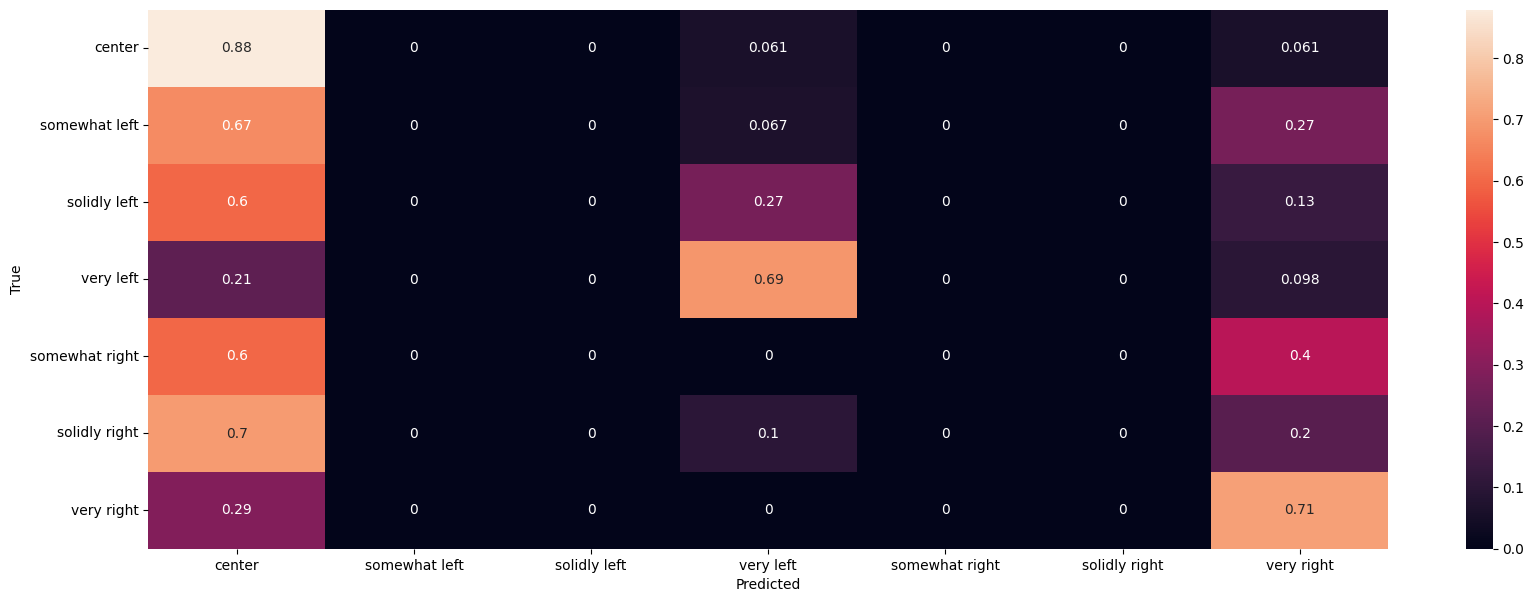

In [ ]:
import seaborn as sns

cm = tf.math.confusion_matrix(y_test, predictions_model_cb)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]
plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=target_names,
    yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")

### Stratified sampling with focal loss

In [ ]:
def create_climatebert_multiclass_focalloss_model(
    num_classes,
    hidden_sizes=[512, 256],
    dropout_rates=[0.5, 0.3],
    learning_rate=2e-5,
):
    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32)

    model_inputs = {
        'input_ids': input_ids,
        'attention_mask': attention_mask
    }

    climatebert_out = climatebert_model(model_inputs)
    pooler_token = climatebert_out['pooler_output']

    # Multiple hidden layers with dropout
    x = pooler_token
    for size, rate in zip(hidden_sizes, dropout_rates):
        x = tf.keras.layers.Dense(size, activation='relu')(x)
        x = tf.keras.layers.Dropout(rate)(x)

    classification = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    classification_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification])

    # Consider focal loss for imbalanced classes
    classification_model.compile(
        optimizer=tf.keras.optimizers.AdamW(learning_rate=learning_rate),
        loss=focal_loss(),
        metrics=['accuracy']
    )

    return classification_model

In [ ]:
focal_loss_climatebert_model = create_climatebert_multiclass_focalloss_model(num_classes=7)

In [ ]:
climatebert_mc_model_fl = create_climatebert_multiclass_focalloss_model(num_classes=len(np.unique(y_train)))
climatebert_mc_model_fl_history = climatebert_mc_model_fl.fit(
    [climatebert_train_encodings.input_ids, climatebert_train_encodings.attention_mask],
    y_train,
    validation_split=0.1,
    epochs=3,
    batch_size=8,
)

Epoch 1/3
94/94 [==============================] - 1957s 21s/step - loss: 1.4903 - accuracy: 0.1606 - val_loss: 1.4904 - val_accuracy: 0.1205
Epoch 2/3
94/94 [==============================] - 1915s 20s/step - loss: 1.4587 - accuracy: 0.1419 - val_loss: 1.4896 - val_accuracy: 0.0964
Epoch 3/3
42/94 [============>.................] - ETA: 17:55 - loss: 1.4147 - accuracy: 0.1815

In [ ]:
#run and capture all predictions from our test set using model.predict

predictions_model_fl=climatebert_mc_model_fl.predict([climatebert_test_encodings.input_ids, climatebert_test_encodings.attention_mask])

#now we need to get the highest probability in the distribution for each prediction
#and store that in a tf.Tensor
predictions_model_fl = tf.argmax(predictions_model_fl, axis=-1)
predictions_model_fl

7/7 [==============================] - 4s 351ms/step


<tf.Tensor: shape=(208,), dtype=int64, numpy=
array([6, 4, 0, 4, 4, 4, 1, 4, 4, 4, 6, 6, 4, 4, 1, 1, 4, 4, 4, 4, 3, 4,
       4, 4, 4, 1, 1, 2, 4, 4, 4, 6, 6, 4, 6, 4, 4, 4, 4, 4, 4, 6, 4, 4,
       0, 6, 4, 4, 4, 6, 1, 6, 4, 6, 4, 2, 6, 6, 4, 4, 1, 4, 6, 4, 4, 6,
       6, 4, 4, 1, 4, 4, 4, 6, 4, 4, 4, 6, 2, 4, 4, 4, 4, 4, 4, 4, 6, 4,
       1, 4, 4, 4, 4, 4, 6, 6, 4, 4, 4, 4, 6, 4, 2, 4, 4, 1, 1, 6, 4, 4,
       4, 4, 6, 4, 4, 6, 4, 0, 4, 4, 4, 2, 4, 4, 6, 4, 4, 4, 3, 6, 1, 4,
       6, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4,
       4, 4, 4, 4, 5, 6, 4, 4, 4, 4, 4, 6, 4, 4, 4, 1, 4, 4, 2, 4, 4, 4,
       3, 4, 4, 4, 4, 4, 4, 4, 4, 1, 6, 4, 6, 2, 1, 4, 4, 2, 4, 6, 1, 2,
       4, 4, 4, 1, 4, 1, 4, 1, 4, 4])>

In [ ]:
print(classification_report(y_test, predictions_model_fl.numpy(), target_names=target_names))

                precision    recall  f1-score   support

        center       0.00      0.00      0.00        66
 somewhat left       0.00      0.00      0.00        15
  solidly left       0.11      0.07      0.08        15
     very left       0.00      0.00      0.00        61
somewhat right       0.04      0.60      0.08        10
 solidly right       0.00      0.00      0.00        10
    very right       0.28      0.32      0.30        31

      accuracy                           0.08       208
     macro avg       0.06      0.14      0.07       208
  weighted avg       0.05      0.08      0.05       208



Text(220.72222222222223, 0.5, 'True')

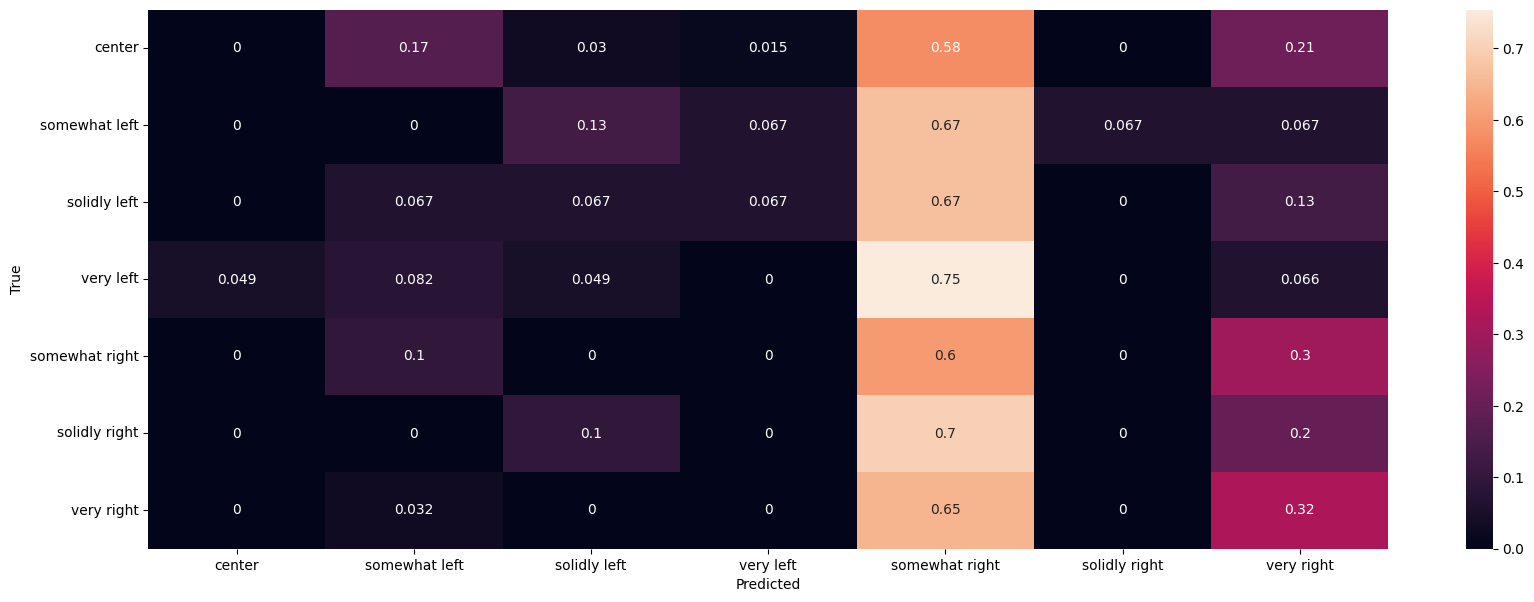

In [ ]:
import seaborn as sns

cm = tf.math.confusion_matrix(y_test, predictions_model_fl)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]
plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=target_names,
    yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")

### Stratified sampling with SMOTE

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import numpy as np

def apply_smote(X_train, y_train, X_test, y_test, vectorizer=None, max_features=1000):
    if vectorizer is None:
        vectorizer = TfidfVectorizer(max_features=max_features)

    # Vectorize training data
    X_train_vectorized = vectorizer.fit_transform(X_train)

    # Vectorize test data
    X_test_vectorized = vectorizer.transform(X_test)

    smote = SMOTE(sampling_strategy='auto', random_state=42)
    # resample training data
    X_resampled, y_resampled = smote.fit_resample(X_train_vectorized, y_train)

    return {
        'X_train_vectorized': X_resampled,
        'y_train_resampled': y_resampled,
        'X_test_vectorized': X_test_vectorized,
        'y_test': y_test,
        'vectorizer': vectorizer
    }

X_train, X_test, y_train, y_test = train_test_split(
    gw_sentences_df['sentence'],
    gw_sentences_df['lean_target'],
    test_size=0.2,
    random_state=42
)

# Apply SMOTE
smote_results = apply_smote(X_train, y_train, X_test, y_test)

X_train_vectorized = smote_results['X_train_vectorized']
y_train_resampled = smote_results['y_train_resampled']
X_test_vectorized = smote_results['X_test_vectorized']
y_test = smote_results['y_test']
vectorizer = smote_results['vectorizer']


def get_resampled_sentences(original_sentences, resampled_features, vectorizer):
    # Vectorize original sentences
    original_vectorized = vectorizer.transform(original_sentences)

    resampled_sentences = []
    for orig_vec in original_vectorized:
        if any((orig_vec != resampled_feat).sum() == 0 for resampled_feat in resampled_features):
            resampled_sentences.append(orig_vec)

    return [original_sentences[original_sentences.index(vec)] for vec in resampled_sentences]

smote_climatebert_train_encodings = climatebert_tokenizer(
    X_train.tolist(),
    max_length=MAX_SEQUENCE_LENGTH,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)

smote_climatebert_test_encodings = climatebert_tokenizer(
    X_test.tolist(),
    max_length=MAX_SEQUENCE_LENGTH,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)

In [26]:
smote_climatebert_model = create_climatebert_multiclass_model(num_classes=7)

In [27]:
climatebert_mc_model_smote = create_climatebert_multiclass_model(num_classes=len(np.unique(y_train)))
climatebert_mc_model_smote_history = climatebert_mc_model_smote.fit(
    [smote_climatebert_train_encodings.input_ids, smote_climatebert_train_encodings.attention_mask],
    y_train,
    validation_split=0.1,
    epochs=3,
    batch_size=8,
)

Epoch 1/3
185/185 [==============================] - 94s 380ms/step - loss: 1.6909 - accuracy: 0.3598 - val_loss: 1.6286 - val_accuracy: 0.5427
Epoch 2/3
185/185 [==============================] - 63s 338ms/step - loss: 1.4308 - accuracy: 0.5427 - val_loss: 1.5491 - val_accuracy: 0.5305
Epoch 3/3
185/185 [==============================] - 62s 336ms/step - loss: 1.1688 - accuracy: 0.6348 - val_loss: 1.4879 - val_accuracy: 0.6037


In [28]:
#run and capture all predictions from our test set using model.predict

predictions_model_smote=climatebert_mc_model_smote.predict([smote_climatebert_test_encodings.input_ids, smote_climatebert_test_encodings.attention_mask])

#now we need to get the highest probability in the distribution for each prediction
#and store that in a tf.Tensor
predictions_model_smote = tf.argmax(predictions_model_smote, axis=-1)
predictions_model_smote

13/13 [==============================] - 6s 378ms/step


<tf.Tensor: shape=(410,), dtype=int64, numpy=
array([3, 3, 3, 0, 0, 3, 3, 6, 3, 3, 0, 3, 3, 3, 6, 3, 0, 0, 6, 0, 3, 3,
       6, 0, 6, 3, 0, 0, 3, 0, 0, 3, 6, 3, 0, 6, 3, 0, 0, 3, 6, 0, 3, 3,
       0, 3, 0, 3, 0, 3, 3, 6, 0, 0, 3, 0, 0, 0, 0, 3, 0, 3, 0, 3, 0, 0,
       6, 3, 0, 3, 0, 6, 6, 0, 0, 0, 6, 0, 0, 0, 3, 6, 3, 0, 3, 0, 0, 6,
       0, 0, 3, 0, 6, 6, 0, 3, 0, 0, 0, 3, 0, 0, 3, 3, 3, 0, 3, 6, 0, 0,
       0, 0, 3, 3, 0, 0, 0, 6, 0, 3, 3, 6, 3, 0, 6, 3, 3, 0, 3, 6, 3, 0,
       0, 0, 3, 0, 3, 0, 6, 3, 3, 3, 0, 6, 3, 6, 6, 3, 0, 0, 6, 0, 6, 3,
       3, 0, 3, 3, 3, 0, 3, 0, 0, 6, 3, 0, 3, 0, 3, 0, 6, 3, 6, 0, 0, 0,
       0, 3, 6, 3, 6, 3, 6, 0, 3, 0, 6, 0, 3, 3, 3, 3, 3, 6, 3, 6, 3, 3,
       3, 3, 0, 6, 0, 3, 0, 0, 3, 0, 0, 3, 3, 3, 0, 0, 3, 6, 0, 0, 0, 0,
       6, 6, 3, 0, 0, 0, 6, 3, 0, 3, 0, 0, 3, 0, 6, 0, 0, 3, 0, 0, 6, 3,
       0, 3, 3, 0, 3, 0, 0, 0, 0, 0, 0, 6, 6, 3, 6, 0, 6, 0, 0, 3, 0, 6,
       3, 0, 6, 0, 3, 3, 3, 3, 6, 0, 0, 0, 0, 0, 3, 0, 0, 3, 3, 3, 0, 3,
     

In [29]:
print(classification_report(y_test, predictions_model_smote.numpy(), target_names=target_names))

                precision    recall  f1-score   support

        center       0.59      0.73      0.65       143
 somewhat left       0.00      0.00      0.00        33
  solidly left       0.00      0.00      0.00        34
     very left       0.56      0.79      0.65       112
somewhat right       0.00      0.00      0.00        20
 solidly right       0.00      0.00      0.00        12
    very right       0.54      0.75      0.63        56

      accuracy                           0.57       410
     macro avg       0.24      0.32      0.28       410
  weighted avg       0.43      0.57      0.49       410



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Text(220.72222222222223, 0.5, 'True')

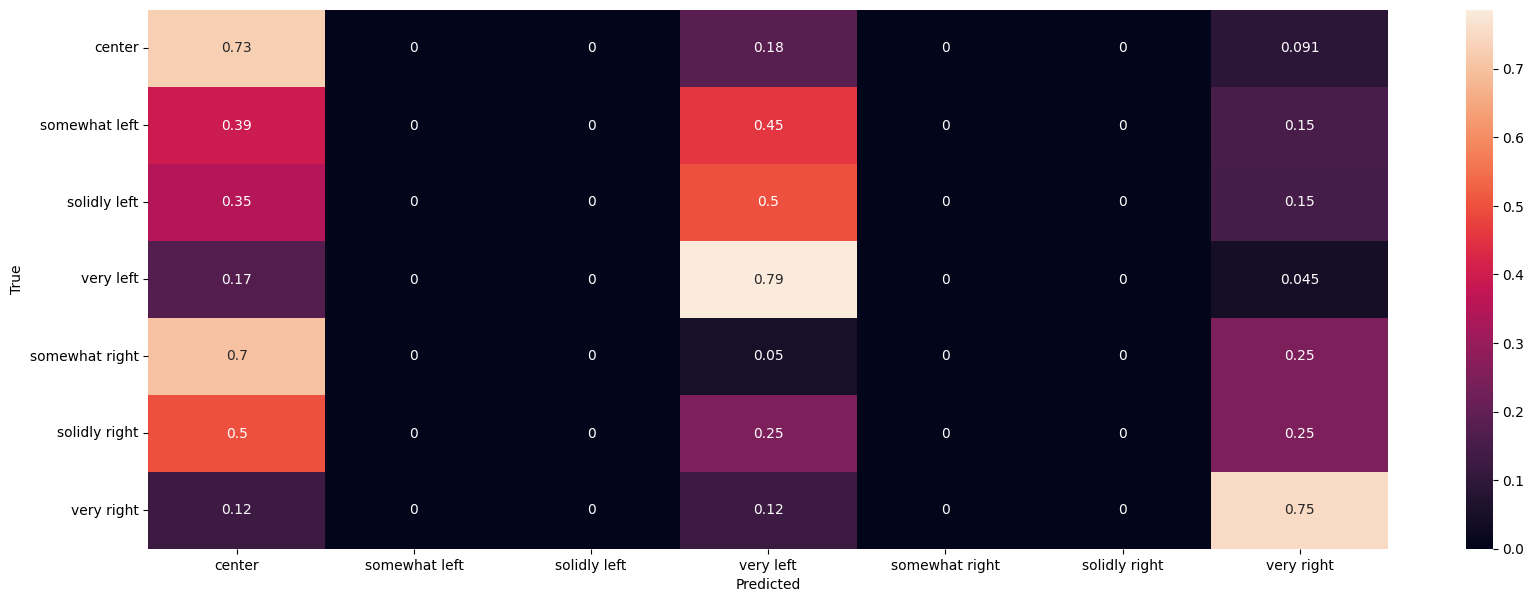

In [30]:
import seaborn as sns

cm = tf.math.confusion_matrix(y_test, predictions_model_smote)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]
plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=target_names,
    yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")

### Stratified sampling with early stopping and learning rate reduction

In [ ]:
# Finetuning

# Early stopping and learning rate reduction
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.7,
    patience=3
)


climatebert_mc_model = create_climatebert_multiclass_model(num_classes=len(np.unique(y_train)))
climatebert_mc_model_history = climatebert_mc_model.fit(
    [climatebert_train_encodings.input_ids, climatebert_train_encodings.attention_mask],
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=16,
    class_weight=class_weights,
    callbacks=[early_stopping, lr_reducer]
)

Epoch 1/50
42/42 [==============================] - 1757s 41s/step - loss: 1.8201 - accuracy: 0.4383 - val_loss: 1.4398 - val_accuracy: 0.5482 - lr: 2.0000e-05
Epoch 2/50
42/42 [==============================] - 1694s 40s/step - loss: 1.4224 - accuracy: 0.6370 - val_loss: 1.4347 - val_accuracy: 0.5904 - lr: 2.0000e-05
Epoch 3/50
39/42 [==========================>...] - ETA: 1:53 - loss: 1.1123 - accuracy: 0.7019

In [56]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.7,
    patience=3
)

In [ ]:
#run and capture all predictions from our test set using model.predict

predictions_model_cbft=climatebert_mc_model.predict([climatebert_test_encodings.input_ids, climatebert_test_encodings.attention_mask])

#now we need to get the highest probability in the distribution for each prediction
#and store that in a tf.Tensor
predictions_model_cbft = tf.argmax(predictions_model_cbft, axis=-1)
predictions_model_cbft

7/7 [==============================] - 4s 353ms/step


<tf.Tensor: shape=(208,), dtype=int64, numpy=
array([6, 3, 3, 0, 3, 0, 0, 3, 3, 0, 6, 0, 0, 3, 0, 0, 6, 3, 3, 6, 6, 0,
       3, 3, 3, 0, 0, 3, 3, 0, 0, 6, 0, 0, 0, 0, 3, 3, 0, 6, 6, 0, 3, 3,
       3, 0, 2, 0, 3, 6, 0, 0, 6, 6, 0, 2, 0, 6, 3, 3, 0, 6, 0, 3, 6, 0,
       0, 3, 3, 0, 0, 6, 0, 0, 3, 3, 3, 6, 0, 0, 6, 6, 0, 0, 0, 0, 6, 0,
       3, 2, 3, 0, 3, 3, 6, 0, 3, 3, 6, 0, 6, 0, 3, 3, 3, 0, 3, 0, 3, 0,
       3, 3, 0, 6, 3, 6, 3, 3, 6, 3, 0, 3, 0, 6, 0, 3, 3, 0, 0, 0, 0, 0,
       6, 3, 6, 6, 6, 3, 3, 3, 6, 0, 0, 6, 0, 3, 3, 0, 6, 0, 0, 3, 6, 3,
       3, 0, 3, 3, 0, 0, 3, 3, 6, 3, 0, 0, 0, 0, 3, 3, 0, 0, 0, 2, 0, 3,
       3, 3, 3, 0, 3, 3, 6, 6, 3, 0, 0, 3, 0, 0, 0, 3, 0, 0, 3, 6, 6, 2,
       3, 6, 0, 3, 3, 6, 6, 0, 0, 0])>

In [ ]:
print(classification_report(y_test, predictions_model_cbft.numpy(), target_names=target_names))

                precision    recall  f1-score   support

        center       0.59      0.76      0.66        66
 somewhat left       0.00      0.00      0.00        15
  solidly left       0.40      0.13      0.20        15
     very left       0.66      0.82      0.73        61
somewhat right       0.00      0.00      0.00        10
 solidly right       0.00      0.00      0.00        10
    very right       0.50      0.68      0.58        31

      accuracy                           0.59       208
     macro avg       0.31      0.34      0.31       208
  weighted avg       0.48      0.59      0.52       208



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Text(220.72222222222223, 0.5, 'True')

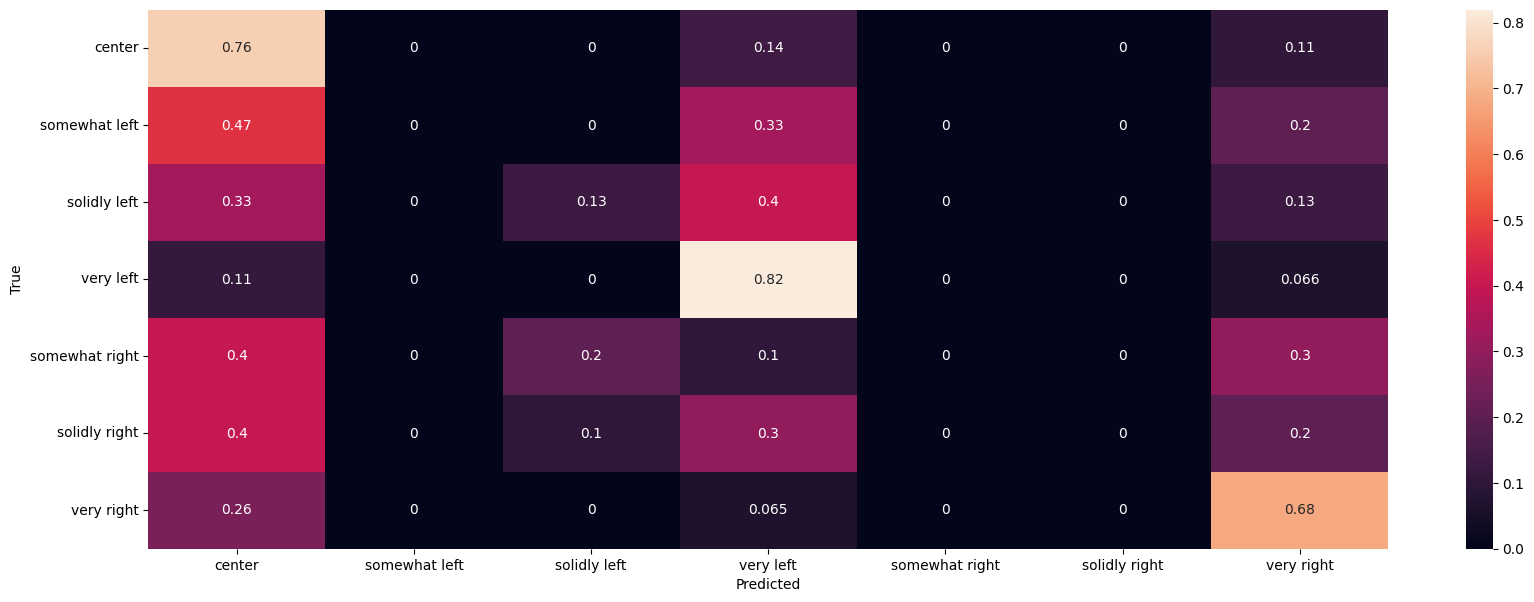

In [ ]:
import seaborn as sns

cm = tf.math.confusion_matrix(y_test, predictions_model_cbft)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]
plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=target_names,
    yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")

## Stratified sampling + early stopping + learning rate reduction + SMOTE

In [31]:
# Finetuning

# Early stopping and learning rate reduction
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.7,
    patience=3
)


climatebert_mc_model_smote_es_lr = create_climatebert_multiclass_model(num_classes=len(np.unique(y_train)))
climatebert_mc_model_smote_es_lr_history = climatebert_mc_model_smote_es_lr.fit(
    [smote_climatebert_train_encodings.input_ids, smote_climatebert_train_encodings.attention_mask],
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=16,
    class_weight=class_weights,
    callbacks=[early_stopping, lr_reducer]
)

Epoch 1/50
82/82 [==============================] - 74s 712ms/step - loss: 1.2544 - accuracy: 0.6006 - val_loss: 1.2444 - val_accuracy: 0.6616 - lr: 2.0000e-05
Epoch 2/50
82/82 [==============================] - 53s 651ms/step - loss: 0.9075 - accuracy: 0.7309 - val_loss: 1.2377 - val_accuracy: 0.6524 - lr: 2.0000e-05
Epoch 3/50
82/82 [==============================] - 54s 662ms/step - loss: 0.7735 - accuracy: 0.7675 - val_loss: 1.2790 - val_accuracy: 0.6402 - lr: 2.0000e-05
Epoch 4/50
82/82 [==============================] - 53s 648ms/step - loss: 0.6887 - accuracy: 0.7820 - val_loss: 1.2971 - val_accuracy: 0.6372 - lr: 2.0000e-05
Epoch 5/50
82/82 [==============================] - 54s 662ms/step - loss: 0.6098 - accuracy: 0.8102 - val_loss: 1.4111 - val_accuracy: 0.5884 - lr: 2.0000e-05
Epoch 6/50
82/82 [==============================] - 54s 660ms/step - loss: 0.5143 - accuracy: 0.8331 - val_loss: 1.5041 - val_accuracy: 0.6098 - lr: 1.4000e-05
Epoch 7/50
82/82 [======================

In [32]:
#run and capture all predictions from our test set using model.predict

predictions_model_smote_es_lr=climatebert_mc_model_smote_es_lr.predict([smote_climatebert_test_encodings.input_ids, smote_climatebert_test_encodings.attention_mask])

#now we need to get the highest probability in the distribution for each prediction
#and store that in a tf.Tensor
predictions_model_smote_es_lr = tf.argmax(predictions_model_smote_es_lr, axis=-1)
predictions_model_smote_es_lr

13/13 [==============================] - 6s 382ms/step


<tf.Tensor: shape=(410,), dtype=int64, numpy=
array([0, 3, 3, 0, 0, 6, 3, 6, 3, 0, 4, 3, 6, 3, 6, 3, 0, 0, 6, 0, 0, 3,
       6, 0, 0, 3, 0, 0, 3, 3, 0, 3, 6, 3, 0, 6, 3, 0, 0, 3, 6, 0, 3, 0,
       3, 3, 0, 3, 0, 3, 3, 0, 0, 1, 3, 0, 0, 0, 0, 3, 0, 3, 0, 3, 0, 0,
       6, 3, 0, 3, 0, 6, 6, 0, 0, 0, 6, 0, 0, 0, 3, 6, 3, 0, 3, 0, 0, 3,
       0, 0, 3, 0, 6, 6, 0, 0, 0, 0, 3, 0, 0, 0, 3, 3, 2, 0, 3, 0, 0, 0,
       0, 0, 3, 3, 0, 0, 0, 6, 0, 0, 3, 6, 3, 0, 6, 3, 3, 0, 3, 6, 0, 0,
       0, 0, 3, 0, 0, 0, 6, 3, 3, 3, 0, 6, 3, 6, 6, 3, 6, 0, 6, 0, 6, 3,
       3, 0, 3, 3, 3, 0, 3, 0, 0, 6, 3, 6, 2, 0, 3, 0, 6, 3, 6, 0, 0, 0,
       0, 3, 6, 3, 6, 1, 6, 0, 3, 0, 6, 0, 3, 3, 3, 3, 3, 6, 3, 6, 3, 3,
       3, 3, 0, 6, 0, 3, 0, 3, 3, 0, 0, 3, 0, 3, 0, 0, 3, 6, 0, 0, 0, 0,
       3, 0, 6, 0, 0, 0, 6, 3, 0, 3, 0, 0, 3, 0, 6, 0, 0, 3, 0, 0, 6, 3,
       0, 3, 3, 0, 3, 0, 0, 0, 0, 6, 0, 6, 0, 3, 0, 0, 6, 0, 0, 3, 0, 6,
       3, 0, 0, 0, 0, 3, 6, 3, 6, 0, 0, 0, 0, 0, 3, 0, 0, 0, 3, 3, 0, 3,
     

In [33]:
print(classification_report(y_test, predictions_model_smote_es_lr.numpy(), target_names=target_names))

                precision    recall  f1-score   support

        center       0.57      0.76      0.65       143
 somewhat left       0.25      0.03      0.05        33
  solidly left       0.00      0.00      0.00        34
     very left       0.62      0.76      0.68       112
somewhat right       0.00      0.00      0.00        20
 solidly right       0.00      0.00      0.00        12
    very right       0.54      0.71      0.62        56

      accuracy                           0.57       410
     macro avg       0.28      0.32      0.29       410
  weighted avg       0.46      0.57      0.50       410



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Text(220.72222222222223, 0.5, 'True')

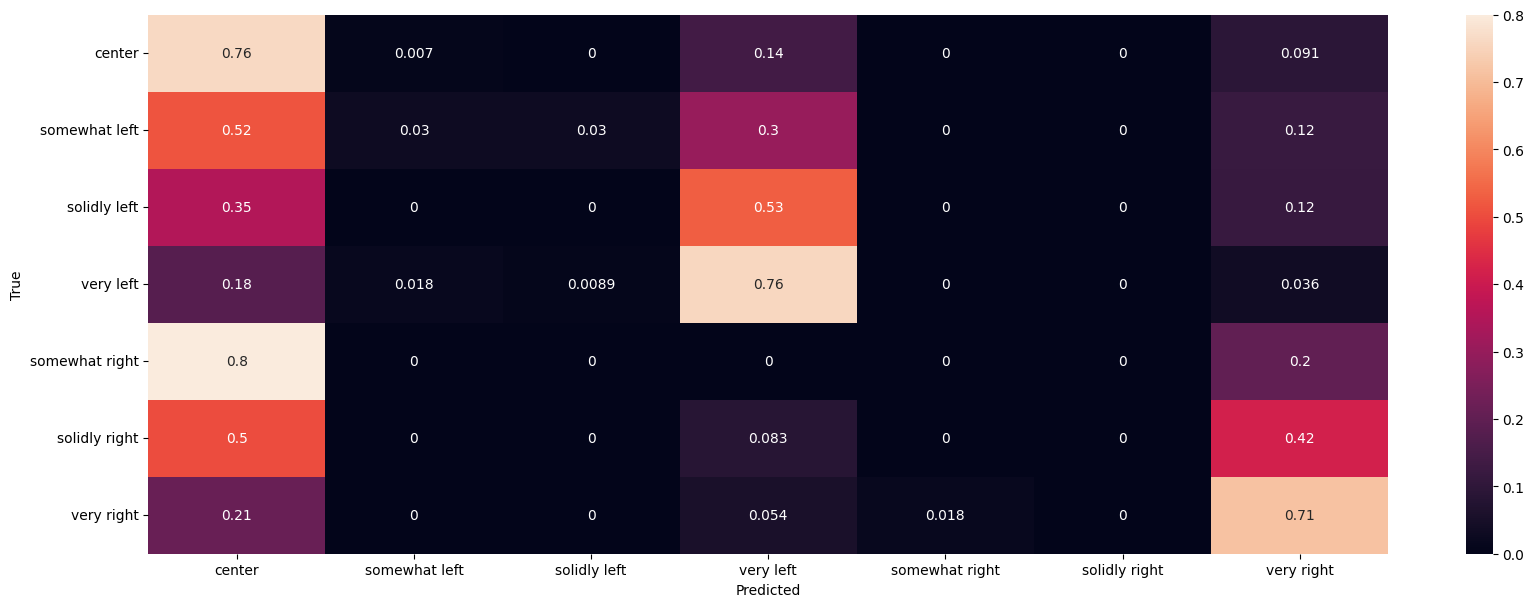

In [34]:
import seaborn as sns

cm = tf.math.confusion_matrix(y_test, predictions_model_smote_es_lr)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]
plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=target_names,
    yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")

# Text Generation

In [8]:
import torch
import transformers
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

In [9]:
t5_model = T5ForConditionalGeneration.from_pretrained('t5-base')
t5_tokenizer = T5Tokenizer.from_pretrained('t5-base')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [10]:
t5_tokenizer = T5Tokenizer.from_pretrained('t5-base')
t5_model = T5ForConditionalGeneration.from_pretrained('t5-base')

In [ ]:
from torch.utils.data import Dataset, DataLoader

class PoliticalStatementDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=300):

        self.tokenizer = tokenizer
        self.max_length = max_length

        # Prepare input and output texts
        self.input_texts = [
            f"Generate a {leaning} political statement about climate change:"
            for leaning in dataframe['political_leaning']
        ]
        self.output_texts = dataframe['sentence'].tolist()

    def __len__(self):
        return len(self.input_texts)

    def __getitem__(self, idx):
        # Tokenize input and output
        input_encoding = self.tokenizer(
            self.input_texts[idx],
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        output_encoding = self.tokenizer(
            self.output_texts[idx],
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': input_encoding['input_ids'].flatten(),
            'attention_mask': input_encoding['attention_mask'].flatten(),
            'labels': output_encoding['input_ids'].flatten()
        }


def split_dataset(dataframe, test_size=0.1, stratify_column='political_leaning'):

    category_counts = dataframe[stratify_column].value_counts()
    print("Category distribution:")
    print(category_counts)

    min_samples = category_counts.min()

    if min_samples < 2: # catch too few samples
        print("Warning: Some categories have very few samples. Falling back to random split.")
        train_df, val_df = train_test_split(
            dataframe,
            test_size=test_size,
            random_state=42
        )
    else:
        train_df, val_df = train_test_split(
            dataframe,
            test_size=test_size,
            stratify=dataframe[stratify_column],
            random_state=42
        )

    return train_df, val_df

def generate_text(
    model,
    tokenizer,
    prompt,
    max_length=300,
    temperature=0.7,
    num_return_sequences=1,
    top_k=50,
    top_p=0.95
):

    # Ensure model is in evaluation mode
    model.eval()

    # Tokenize the input
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        max_length=max_length,
        truncation=True
    )

    # Generate text with advanced parameters
    with torch.no_grad():
        outputs = model.generate(
            inputs.input_ids,
            attention_mask=inputs.attention_mask,
            max_length=max_length,
            num_return_sequences=num_return_sequences,
            temperature=temperature,
            top_k=top_k,
            top_p=top_p,
            do_sample=True,  # Enable sampling
            repetition_penalty=1.2,  # Reduce repetitions
            no_repeat_ngram_size=2  # Avoid repeating 2-gram sequences
        )

    # Decode the generated text
    generated_texts = [
        tokenizer.decode(output, skip_special_tokens=True)
        for output in outputs
    ]

    return generated_texts[0] if num_return_sequences == 1 else generated_texts

def bulk_generate_political_statements(
    t5_model,
    t5_tokenizer,
    political_leanings=np.unique(gw_sentences_df['political_leaning']),
    statements_per_leaning=100,
    max_length=150,
    temperature=0.7,
    seed=1234
):
    torch.manual_seed(seed)
    np.random.seed(seed)
    t5_model.eval()

    generated_statements = []

    for leaning in political_leanings:
        print(f"Generating {statements_per_leaning} {leaning} statements...")

        for _ in range(statements_per_leaning):
            # prompt
            prompt = f"Generate a {leaning} political statement about climate change:"

            generated_text = generate_text(
                t5_model,
                t5_tokenizer,
                prompt,
                max_length=max_length,
                temperature=temperature
            )

            generated_statements.append({
                'political_leaning': leaning,
                'sentence': generated_text
            })

    df_generated = pd.DataFrame(generated_statements)

    return df_generated


def main():

    political_leanings = np.unique(gw_sentences_df['political_leaning'])
    sentences = gw_sentences_df['sentence']

    sample_df = pd.DataFrame({
      'political_leaning': gw_sentences_df['political_leaning'],
      'sentence': gw_sentences_df['sentence']
       })

    train_dataset, val_dataset = split_dataset(sample_df)

    train_dataset = PoliticalStatementDataset(train_dataset, t5_tokenizer)
    val_dataset = PoliticalStatementDataset(val_dataset, t5_tokenizer)

    generated_df = bulk_generate_political_statements(
        t5_model,
        t5_tokenizer,
        statements_per_leaning=100,
        max_length=150
    )

    # save generated statements to CSV to improve GPU space usage
    generated_df.to_csv('/content/drive/MyDrive/w266/Final Project/generated_political_statements.csv', index=False)

    print("\nGeneration Summary:")
    print(generated_df['political_leaning'].value_counts())

    # testing
    # print("\nSample Generated Statements:")
    # for leaning in gw_sentensummary(model, input_size=(1, 300))ces_df['political_leaning']:
    #     print(f"\n{leaning.capitalize()} Statements:")
    #     sample_statements = generated_df[generated_df['political_leaning'] == leaning]['sentence'].sample(3)
    #     for statement in sample_statements:
    #         print(f"- {statement}")

if __name__ == '__main__':
    main()

Category distribution:
political_leaning
center            656
very left         611
very right        306
solidly left      157
somewhat left     149
somewhat right     89
solidly right      82
Name: count, dtype: int64
Generating 100 center statements...
Generating 100 solidly left statements...
Generating 100 solidly right statements...
Generating 100 somewhat left statements...
Generating 100 somewhat right statements...
Generating 100 very left statements...
Generating 100 very right statements...

Generation Summary:
political_leaning
center            100
solidly left      100
solidly right     100
somewhat left     100
somewhat right    100
very left         100
very right        100
Name: count, dtype: int64


In [13]:
print(t5_model)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

print(f"Total Parameters: {count_parameters(t5_model):,}")

Total Parameters: 222,903,552


## Assessing output results with SMOTE + LR + ES + stratified sampling ClimateBERT model

In [35]:
generated_df = pd.read_csv('/content/drive/MyDrive/MIDS 266/Final Project/generated_political_statements.csv')
generated_df['lean_target'] = generated_df['political_leaning'].map({'center': 0.0, 'somewhat left': 1.0, 'solidly left': 2.0, 'very left': 3.0, 'somewhat right': 4.0, 'solidly right': 5.0, 'very right': 6.0})
generated_df['lean_target'].value_counts()


,count
lean_target,
0.0,100
2.0,100
5.0,100
1.0,100
4.0,100
3.0,100
6.0,100


In [36]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# using a sentence transformer model to compare semantic similarity
sentence_transformer_model = SentenceTransformer('all-MiniLM-L6-v2')
# need a function to compute cosine similarity between the same classes
def compute_class_semantic_similarity(df1, df2, class_column='political_leaning'):
    # unique classes in the dataset
    classes = df1[class_column].unique()
    # putting results in a dict
    class_similarities = {}

    for cls in classes:
        class1_sentences = df1[df1[class_column] == cls]['sentence'].tolist()
        class2_sentences = df2[df2[class_column] == cls]['sentence'].tolist()

        class1_embeddings = sentence_transformer_model.encode(class1_sentences)
        class2_embeddings = sentence_transformer_model.encode(class2_sentences)

        # pairwise cosine similarities
        similarity_matrix = cosine_similarity(class1_embeddings, class2_embeddings)
        avg_similarity = np.mean(similarity_matrix)

        class_similarities[cls] = {
            'avg_similarity': avg_similarity,
            'original_count': len(class1_sentences),
            'generated_count': len(class2_sentences)
        }

    return class_similarities

similarities = compute_class_semantic_similarity(gw_sentences_df, generated_df)

for cls, stats in similarities.items():
    print(f"Class: {cls}")
    print(f"  Average Semantic Similarity: {stats['avg_similarity']:.4f}")
    print(f"  Original Sentences: {stats['original_count']}")
    print(f"  Generated Sentences: {stats['generated_count']}")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Class: solidly left
  Average Semantic Similarity: 0.3166
  Original Sentences: 157
  Generated Sentences: 100
Class: center
  Average Semantic Similarity: 0.2800
  Original Sentences: 656
  Generated Sentences: 100
Class: very right
  Average Semantic Similarity: 0.3817
  Original Sentences: 306
  Generated Sentences: 100
Class: solidly right
  Average Semantic Similarity: 0.3627
  Original Sentences: 82
  Generated Sentences: 100
Class: very left
  Average Semantic Similarity: 0.3368
  Original Sentences: 611
  Generated Sentences: 100
Class: somewhat left
  Average Semantic Similarity: 0.3052
  Original Sentences: 149
  Generated Sentences: 100
Class: somewhat right
  Average Semantic Similarity: 0.3342
  Original Sentences: 89
  Generated Sentences: 100
